## 다이나믹 프로그래밍

다이나믹 프로그래밍은 model-based 접근법으로, 환경의 전이 확률과 보상을 알고 있을 때 사용됩니다. 이번 코드에서는 DP 기법의 가치 이터레이션 (Value Iteration), 정책 이터레이션 (Policy Iteration)을 활용해 최적 정책을 찾습니다.

다음 환경(**GridWorldEnvironment**)을 가지고 가치 이터레이션, 정책 이터레이션을 구현하세요.

## GridWorldEnvironment
GridWorld는 격자 기반 환경으로, 에이전트가 상, 하, 좌, 우로 이동하며 목표 지점에 도달해야 합니다.

```py
start_point = (0,0) # 시작점
end_point = (4,4) # 목표 지점
gridworld_size = (5,5) # 5x5 크기의 격자
env = GridWorldEnvironment(start_point, end_point, grid_world_size)
```

## Original Code

In [2]:
import numpy as np
from typing import Tuple

class GridWorldEnvironment:
    def __init__(self, start_point: Tuple, end_point: Tuple, grid_world_size: Tuple):
        # 시작점과 끝점을 받는다.
        self.start_point = start_point
        self.end_point = end_point if end_point != (-1,-1) else (grid_world_size[0] + end_point[0],
                                                                 grid_world_size[1] + end_point[1])

        # 그리드 월드의 규격을 받는다.
        self.width, self.height = grid_world_size

        # action dictionary
        self.action_space = ['up', 'down', 'left', 'right']
        self.num_actions = len(self.action_space)
        self.actions = {'up':(-1,0),
                        'down':(1,0),
                        'left':(0,-1),
                        'right':(0,1) }

        # 상태 : 좌표로 나타남
        self.traces = []

        # total states
        self.total_states = [] # 모든 좌표를 저장함
        for x in range(self.width):
            for y in range(self.height):
                self.total_states.append((x,y))

        # reward
        self.reward = np.zeros(shape=(self.height, self.width)).tolist() # 보상을 모두 0으로 설정
        self.reward[end_point[0]][end_point[1]] = 1 # 목표 지점의 보상은 1

    def render(self):
        # 그리드 월드의 상태를 출력한다.
        self.grid_world = np.full(shape=(self.height, self.width), fill_value=".").tolist()

        last_point = self.traces[-1] # 에이전트가 가장 마지막에 있었던 위치
        traces = list(set(self.traces)) # 중복된 값을 삭제하기 위함
        for trace in traces:
            self.grid_world[trace[0]][trace[1]] = "X" # 지나간 곳은 X로 표시

        self.grid_world[self.start_point[0]][self.start_point[1]] = "S" # start point
        self.grid_world[self.end_point[0]][self.end_point[1]] = "G" # end point
        self.grid_world[last_point[0]][last_point[1]] = "A" # 현재 에이전트의 위치

        # string으로 출력한다.
        grid = ""

        for i in range(self.height):
            for j in range(self.width):
                grid += self.grid_world[i][j]+" "
            grid += "\n"

        print(grid)

    def get_reward(self, state, action_idx):
        # 특정 상태에서 행동했을 때 이동한 다음 칸의 보상을 반환함
        next_state = self.state_after_action(state, action_idx)
        return self.reward[next_state[0]][next_state[1]]

    def state_after_action(self, state, action_idx:int):
        # 특정 상태에서 특정 행동을 하면 가게 되는 다음 상태 반환
        action = self.action_space[action_idx]
        row_movement, col_movement = self.actions[action]

        # action에 따라 에이전트 이동
        next_state = (state[0]+row_movement, state[1]+col_movement)
        next_state = self.check_boundary(next_state)

        return next_state

    def check_boundary(self, state):
        state = list(state)
        state[0] = (0 if state[0] < 0 else self.height - 1 if state[0] > self.height - 1 else state[0])
        state[1] = (0 if state[1] < 0 else self.width - 1 if state[1] > self.width - 1 else state[1])
        return tuple(state)

## Own Code
위 환경 클래스를 상속 받아 `env.render` 코드를 구현하세요.

In [3]:
class GridWorld(GridWorldEnvironment):
    def __init__(self, start_point, end_point, grid_world_size):
        super().__init__(start_point, end_point, grid_world_size)

    def render(self):
        super().render()

# 01. 정책 이터레이션
정책 이터레이션은 정책 평가와 정책 개선을 번갈아 수행하며 최적 정책을 찾아가는 방법입니다.

- 스켈레톤 코드  
`init` 부를 제외한 나머지 매소드를 채워주세요.

1. get_policy : 현재 상태에서의 정책 반환
2. get_value	: 현재 상태의 가치 반환
3. get_action : 현재 정책에 따라 행동 선택
4. policy_evaluation : 정책을 기준으로 가치 함수 업데이트
5. policy_improvement : 가치 함수를 이용해 최적 정책을 찾음

In [17]:
import copy

class PolicyIteration:
    def __init__(self,env):
        # about env
        self.env = env
        self.action_space = env.action_space # ['up', 'down', 'left', 'right'] 차례대로 (-1,0) (1,0) (0,-1) (0,1)
        self.num_action = len(self.action_space)

        # value 2d list
        self.value_table = np.zeros(shape = (env.height, env.width)).tolist() # Appendix 1

        # 상하좌우 동일한 확률을 가지는 정책으로 초기화
        self.policy_table = np.full(shape = (env.height, env.width, self.num_action), fill_value = 1/self.num_action).tolist()

        # end state 에서는 어떠한 행동도 할 필요가 없어서 policy table을 비운다.
        self.policy_table[env.end_point[0]][env.end_point[1]] = []

        self.gamma = 0.9 # 할인율

    def get_policy(self, state):
        """
        현재 상태에서의 정책 반환
        5x5x4(행동 개수)의 리스트에서 현재 상태에 대한 정책 반환함
        ex) [0.25, 0.25, 0.25, 0.25]
        """
        return self.policy_table[state[0]][state[1]]


    def get_value(self, state):
        """
        현재 상태의 가치함수 값 반환
        5x5의 리스트에서 현재 상태에 대한 가치함수의 값을 반환함
        """
        return self.value_table[state[0]][state[1]]


    def get_action(self,state):
        """
        현재 정책에 따라 행동 선택
        상하좌우 4개의 행동에서 하나의 행동을 policy 따라 샘플링
        np.random.choice(행동 개수, 행동 샘플링 개수, 각 행동을 얼마의 확률로 샘플링할 건지)
        """
        policy = self.get_policy(state) # 현재 상태에 대한 정책을 policy에 저장
        return np.random.choice(self.num_action, 1, p=policy)


    def policy_evaluation(self):
        """
        정책을 기준으로 가치 함수 업데이트
        """
        next_value_table = np.copy(self.value_table)

        for state in self.env.total_states:
            value = 0 # end point의 가치함수
            if state == self.env.end_point:
                next_value_table[state[0]][state[1]] = value
                # state가 end point이면 0을 저장함
                continue

            policy = self.get_policy(state) # 현재 정책

            for action_idx in range(self.num_action): # 0,1,2,3
                next_state = self.env.state_after_action(state, action_idx)
                reward = self.env.get_reward(state, action_idx)
                next_value = self.get_value(next_state)
                value += policy[action_idx] * (reward + self.gamma * next_value)

            next_value_table[state[0]][state[1]] = value

        self.value_table = next_value_table

    def policy_improvement(self):
        """
        가치 함수를 이용해 최적 정책을 찾음
        """
        flag = True
        next_policy = copy.deepcopy(self.policy_table)

        for state in self.env.total_states:
            if state == self.env.end_point:
                continue

            old_policy = self.get_policy(state)
            values = []

            for action_idx in range(self.num_action): # 0,1,2,3
                # 모든 행동에 대해 계산
                next_state = self.env.state_after_action(state, action_idx)
                reward = self.env.get_reward(state, action_idx)
                next_value = self.get_value(next_state)
                value = reward + self.gamma * next_value
                values.append(value)

            # 최적 행동 찾기
            max_idx_list = np.argwhere(values == np.max(values))
            max_idx_list = max_idx_list.flatten().tolist()
            prob = 1 / len(max_idx_list)

            result = [0] * self.num_action
            for idx in max_idx_list:
                result[idx] = prob

            next_policy[state[0]][state[1]] = result

            if old_policy != result:
                flag = False

        self.policy_table = next_policy
        return flag

## 정책 이터레이션 실행
정의한 클래스를 이용해 정책 이터레이션을 실행해 주세요.

In [27]:
if __name__ == "__main__":
    start_point = (0,0) # 시작점
    end_point = (4,4) # 목표 지점
    grid_world_size = (5,5) # 5x5 크기의 격자
    env = GridWorldEnvironment(start_point, end_point, grid_world_size)

    agent = PolicyIteration(env)
    step_counts = []

    while True:
        agent.policy_evaluation()
        policy_stable = agent.policy_improvement()

        state = env.start_point
        env.traces = [state]
        step = 0

        while state != env.end_point:
            action = agent.get_action(state).item()
            next_state = env.state_after_action(state, action)
            env.traces.append(next_state)
            state = next_state
            step += 1

        env.render()
        step_counts.append(step)

        if policy_stable:
            break

S X X X . 
X X X . . 
. . X X X 
. . . . X 
. . . . A 

S X X . . 
. . X X X 
. . . . X 
. . . . X 
. . . . A 

S X . . . 
. X . . . 
. X X . . 
. . X . . 
. . X X A 

S . . . . 
X . . . . 
X . . . . 
X . . . . 
X X X X A 

S X . . . 
. X X . . 
. . X . . 
. . X X X 
. . . . A 

S X . . . 
. X X . . 
. . X X . 
. . . X . 
. . . X A 

S X X . . 
. . X X X 
. . . . X 
. . . . X 
. . . . A 

S . . . . 
X X X . . 
. . X X . 
. . . X . 
. . . X A 



## 학습에서 중요한 정보
학습이 되고 있는 것을 판단할 수 있는 파라미터를 찾아 시각화해 주세요.

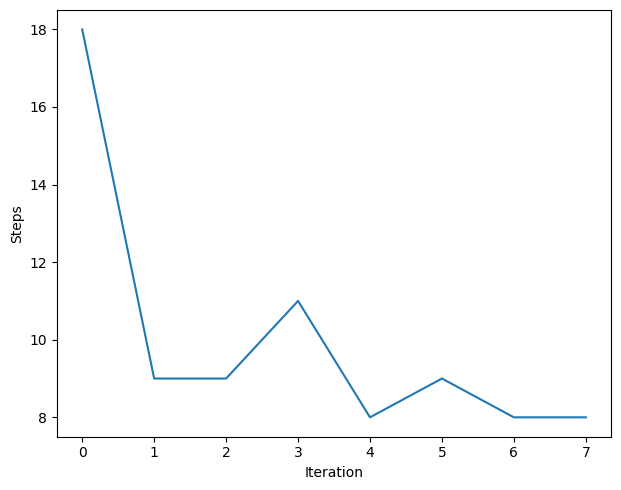

In [29]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 2)
plt.plot(step_counts)
plt.xlabel("Iteration")
plt.ylabel("Steps")

plt.tight_layout()
plt.show()

# 02. 가치 이터레이션
가치 이터레이션은 정책 없이 직접 가치 함수를 최적화하는 방법입니다.
- 스켈레톤 코드  
`init` 부를 제외한 나머지 매소드를 채워주세요.
1. value_iteration : 벨만 최적 방정식을 이용해 가치 함수를 반복적으로 업데이트
2. get_value : 현재 상태의 가치를 반환
3. get_action : 현재 가치 함수 기준으로 최적 행동 선택

In [54]:
import random

class ValueIteration:
    def __init__(self, env):

        self.env = env
        self.action_space = env.action_space
        self.num_actions = env.num_actions

        # value 2d list
        self.value_table = np.zeros(shape=(env.height, env.width)).tolist()

        self.gamma = 0.9 # 할인율

    def value_iteration(self):
        delta = 0
        next_value_table = np.copy(self.value_table)

        for state in self.env.total_states:
            if state == self.env.end_point:
                continue

            values = []
            for action_idx in range(self.num_actions):
                    next_state = self.env.state_after_action(state, action_idx)
                    reward = self.env.get_reward(state, action_idx)
                    next_value = self.get_value(next_state)
                    value = reward + self.gamma * next_value
                    values.append(value)

            max_value = max(values)
            old_value = self.value_table[state[0]][state[1]]
            delta = max(delta, abs(old_value - max_value))

            next_value_table[state[0]][state[1]] = max_value

        self.value_table = next_value_table
        return delta

    def get_action(self, state):
        if state == self.env.end_point:
            return []

        values = []

        for action_idx in range(self.num_actions):
            next_state = self.env.state_after_action(state, action_idx)
            reward = self.env.get_reward(state, action_idx)
            next_value = self.get_value(next_state)
            value = reward + self.gamma * next_value
            values.append(value)

        max_value = max(values)
        max_idx_list = [i for i, v in enumerate(values) if v == max_value]

        return random.choice(max_idx_list)

    def get_value(self, state):
        return self.value_table[state[0]][state[1]]

## 가치 이터레이션 실행
정의한 클래스를 이용해 가치 이터레이션을 실행해 주세요.

In [56]:
if __name__ == "__main__":
    start_point = (0,0) # 시작점
    end_point = (4,4) # 목표 지점
    grid_world_size = (5,5) # 5x5 크기의 격자
    env = GridWorldEnvironment(start_point, end_point, grid_world_size)

    agent = ValueIteration(env)

    threshold = 0.0001
    delta_list = []
    step_list = []

    while True:
        delta = agent.value_iteration()
        delta_list.append(delta)

        state = env.start_point
        env.traces = [state]
        step = 0

        while state != env.end_point:
            action = agent.get_action(state)
            next_state = env.state_after_action(state, action)
            env.traces.append(next_state)
            state = next_state
            step += 1

        env.render()
        step_list.append(step)

        if delta < threshold:
            break


S X X X . 
X X X X . 
X X X . . 
X X X . . 
. X X X A 

S X X X X 
X . . . X 
X X . . X 
X X . . X 
. . . . A 

S . . . . 
X X . . . 
X X . . . 
X . . . . 
X X X X A 

S X X . . 
. X X X . 
. . . X . 
. . . X . 
. . . X A 

S X . . . 
. X . . . 
. X X X X 
. . . . X 
. . . . A 

S . . . . 
X X X X X 
. . . . X 
. . . . X 
. . . . A 

S X . . . 
. X X . . 
. . X X . 
. . . X X 
. . . . A 

S X . . . 
. X . . . 
. X . . . 
. X X . . 
. . X X A 

S X . . . 
. X X X X 
. . . . X 
. . . . X 
. . . . A 



## 학습에서 중요한 정보
학습이 되고 있는 것을 판단할 수 있는 파라미터/요소를 찾아 시각화해 주세요.

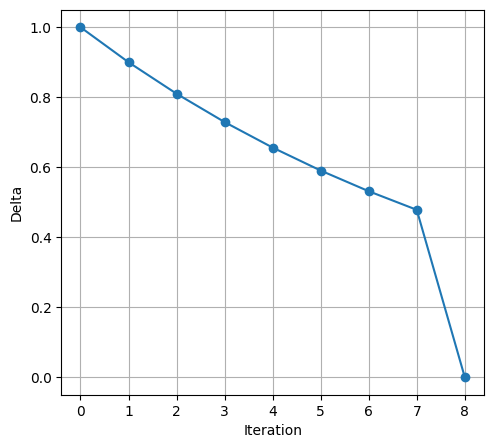

In [59]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(delta_list, marker='o')
plt.xlabel("Iteration")
plt.ylabel("Delta")
plt.grid()

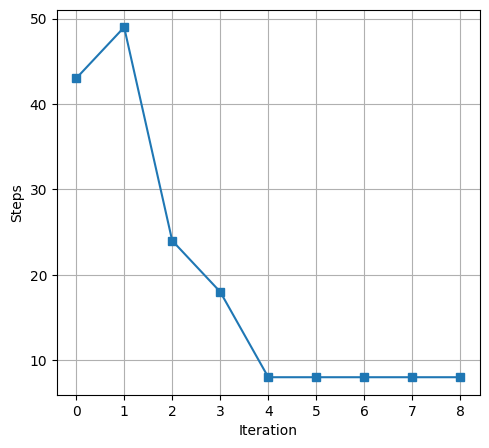

In [60]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 2)
plt.plot(step_list, marker='s')
plt.xlabel("Iteration")
plt.ylabel("Steps")
plt.grid()